# Feature Importance Analysis

Analyze global feature importance from the trained model.

**Acceptance Criteria:**
- Top features identified
- Business relevance explained

**Deliverables:**
- Feature importance plots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'lightgbm'

## 1. Train Model & Extract Importance

In [ ]:
# Load data
df = pd.read_csv('../data/processed/final_train_features.csv')
X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df['TARGET']

for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Features: {X.shape[1]}")

Features: 132


In [ ]:
# Train LightGBM
model = lgb.train(
    {'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'random_state': 42},
    lgb.Dataset(X_train, label=y_train),
    num_boost_round=500,
    valid_sets=[lgb.Dataset(X_test, label=y_test)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

# Extract importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance_gain': model.feature_importance(importance_type='gain'),
    'importance_split': model.feature_importance(importance_type='split')
}).sort_values('importance_gain', ascending=False).reset_index(drop=True)

print(f"Model trained. Top 5 features:")
feature_importance.head()

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[148]	valid_0's auc: 0.774158
Model trained. Top 5 features:


,feature,importance_gain,importance_split
0,EXT_SOURCE_2,28678.198829,153
1,EXT_SOURCE_3,27730.520099,141
2,ORGANIZATION_TYPE,12247.919411,500
3,LATE_PAYMENT_RATE,4755.914261,108
4,BUREAU_DEBT_CREDIT_RATIO,3748.595943,77


## 2. Feature Importance Plots

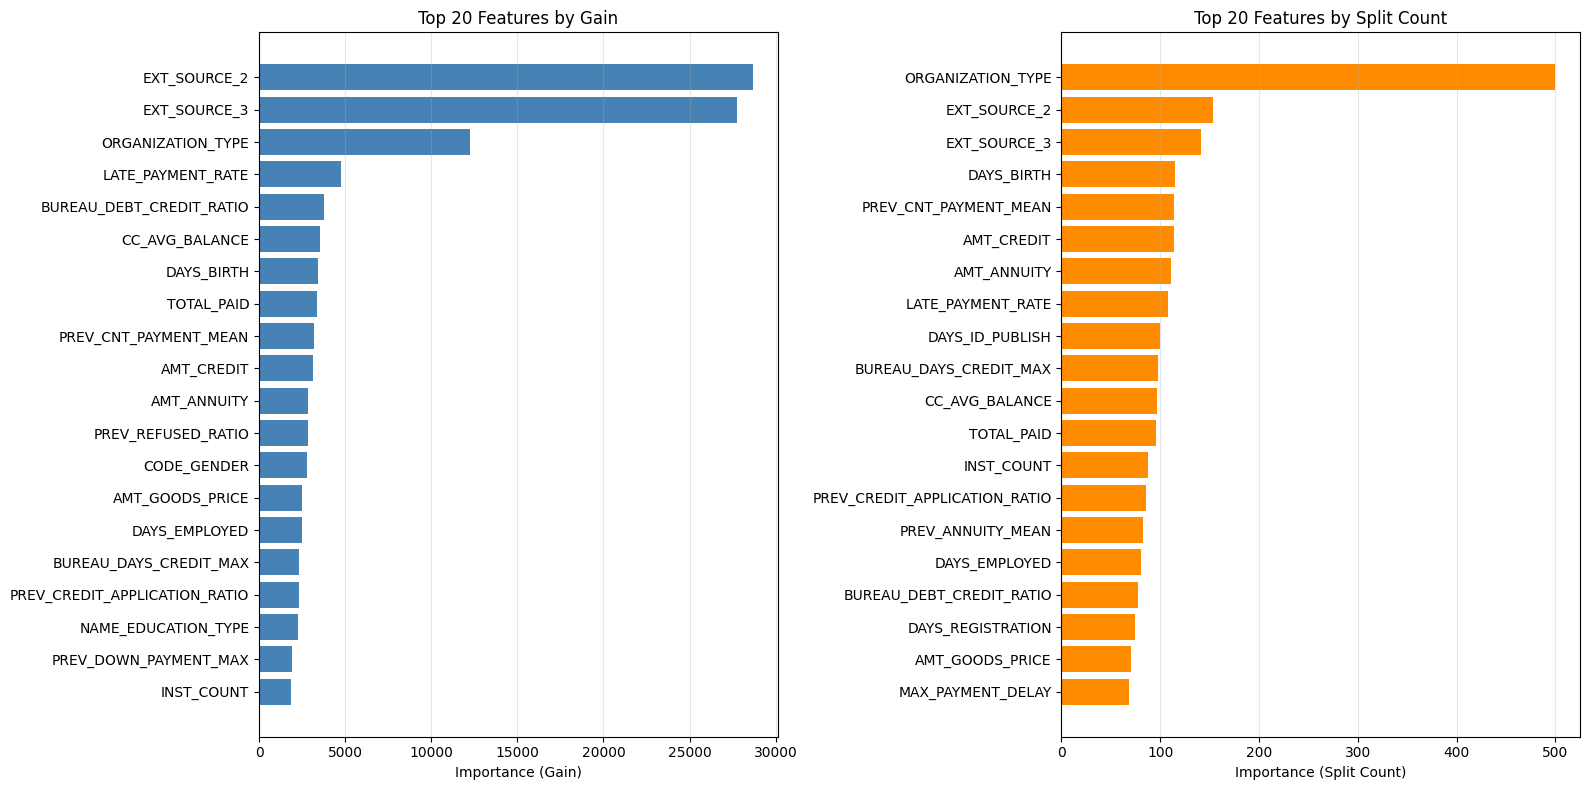

In [ ]:
# Top 20 Features by Gain and Split
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

top20 = feature_importance.head(20)
axes[0].barh(top20['feature'][::-1], top20['importance_gain'][::-1], color='steelblue')
axes[0].set_xlabel('Importance (Gain)')
axes[0].set_title('Top 20 Features by Gain')
axes[0].grid(axis='x', alpha=0.3)

top20_split = feature_importance.sort_values('importance_split', ascending=False).head(20)
axes[1].barh(top20_split['feature'][::-1], top20_split['importance_split'][::-1], color='darkorange')
axes[1].set_xlabel('Importance (Split Count)')
axes[1].set_title('Top 20 Features by Split Count')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

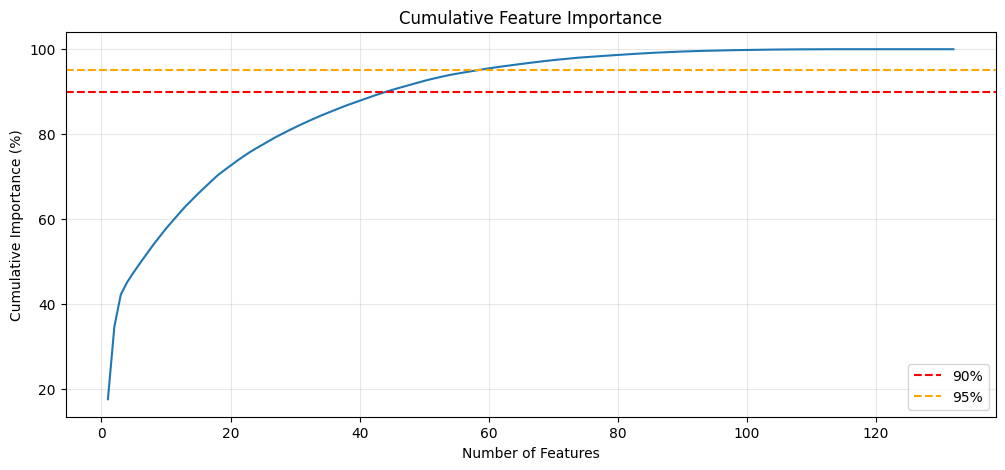

Features for 90% importance: 45/132
Features for 95% importance: 58/132


In [ ]:
# Cumulative importance
feature_importance['importance_pct'] = feature_importance['importance_gain'] / feature_importance['importance_gain'].sum() * 100
feature_importance['cumulative_pct'] = feature_importance['importance_pct'].cumsum()

plt.figure(figsize=(12, 5))
plt.plot(range(1, len(feature_importance) + 1), feature_importance['cumulative_pct'].values)
plt.axhline(y=90, color='red', linestyle='--', label='90%')
plt.axhline(y=95, color='orange', linestyle='--', label='95%')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance (%)')
plt.title('Cumulative Feature Importance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

n_90 = (feature_importance['cumulative_pct'] <= 90).sum() + 1
n_95 = (feature_importance['cumulative_pct'] <= 95).sum() + 1
print(f"Features for 90% importance: {n_90}/{len(feature_importance)}")
print(f"Features for 95% importance: {n_95}/{len(feature_importance)}")

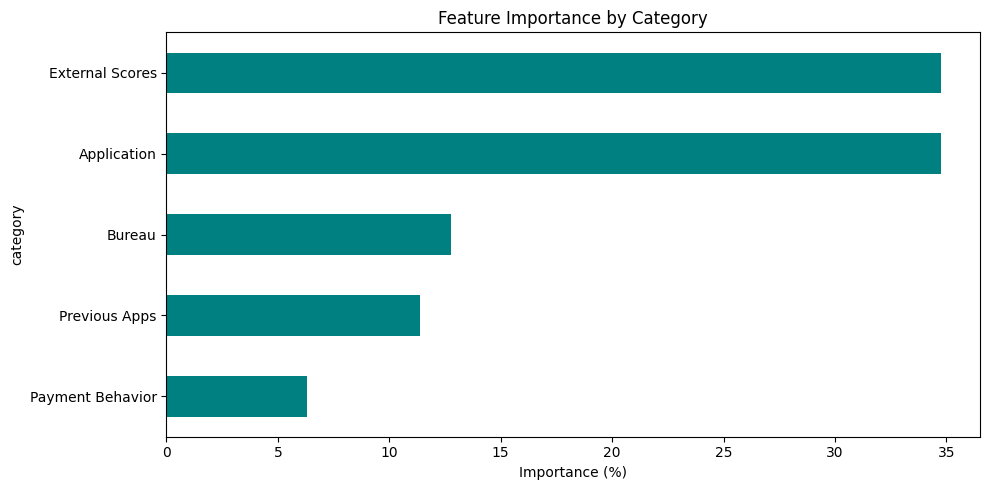

In [ ]:
# Feature importance by category
def categorize(name):
    if name.startswith('BUREAU_'): return 'Bureau'
    elif name.startswith('PREV_'): return 'Previous Apps'
    elif name.startswith('EXT_SOURCE'): return 'External Scores'
    elif 'PAYMENT' in name or 'PAID' in name or 'LATE' in name: return 'Payment Behavior'
    else: return 'Application'

feature_importance['category'] = feature_importance['feature'].apply(categorize)
cat_summary = feature_importance.groupby('category')['importance_gain'].sum()
cat_summary = (cat_summary / cat_summary.sum() * 100).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
cat_summary.plot(kind='barh', color='teal')
plt.xlabel('Importance (%)')
plt.title('Feature Importance by Category')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 3. Top Features Identified

In [ ]:
print("TOP 20 FEATURES")
print("=" * 50)
for i, row in feature_importance.head(20).iterrows():
    print(f"{i+1:2}. {row['feature']:40} {row['importance_pct']:5.1f}%")

TOP 20 FEATURES
 1. EXT_SOURCE_2                              17.7%
 2. EXT_SOURCE_3                              17.1%
 3. ORGANIZATION_TYPE                          7.5%
 4. LATE_PAYMENT_RATE                          2.9%
 5. BUREAU_DEBT_CREDIT_RATIO                   2.3%
 6. CC_AVG_BALANCE                             2.2%
 7. DAYS_BIRTH                                 2.1%
 8. TOTAL_PAID                                 2.1%
 9. PREV_CNT_PAYMENT_MEAN                      2.0%
10. AMT_CREDIT                                 1.9%
11. AMT_ANNUITY                                1.8%
12. PREV_REFUSED_RATIO                         1.7%
13. CODE_GENDER                                1.7%
14. AMT_GOODS_PRICE                            1.5%
15. DAYS_EMPLOYED                              1.5%
16. BUREAU_DAYS_CREDIT_MAX                     1.4%
17. PREV_CREDIT_APPLICATION_RATIO              1.4%
18. NAME_EDUCATION_TYPE                        1.4%
19. PREV_DOWN_PAYMENT_MAX                      1

## 4. Business Relevance Explained

In [ ]:
explanations = {
    'EXT_SOURCE_3': ('External credit score #3', 
        'Third-party credit bureau score. Strongest predictor - low scores correlate with high default risk.'),
    'EXT_SOURCE_2': ('External credit score #2', 
        'Independent credit assessment. Provides validation of creditworthiness from external source.'),
    'EXT_SOURCE_1': ('External credit score #1', 
        'Primary external score. Missing values may indicate thin credit file (new to credit).'),
    'ORGANIZATION_TYPE': ('Employer organization type', 
        'Industry/sector of employment affects income stability. Some industries have higher default rates.'),
    'DAYS_BIRTH': ('Applicant age (days)', 
        'Older applicants show lower default rates due to financial stability and experience.'),
    'DAYS_EMPLOYED': ('Employment duration (days)', 
        'Job stability indicator. Longer employment = stable income = lower risk.'),
    'AMT_CREDIT': ('Loan credit amount', 
        'Larger loans relative to income increase repayment burden and default probability.'),
    'AMT_ANNUITY': ('Loan annuity (monthly payment)', 
        'High monthly payments strain household budget. Annuity-to-income ratio is key.'),
    'AMT_GOODS_PRICE': ('Price of goods purchased', 
        'Gap between goods price and credit amount indicates down payment capability.'),
    'BUREAU_DEBT_CREDIT_RATIO': ('Debt-to-credit ratio (bureau)', 
        'Credit utilization from external sources. High utilization = financial stress.'),
    'LATE_PAYMENT_RATE': ('Historical late payment rate', 
        'Past payment behavior is the best predictor of future behavior. History repeats.'),
    'PREV_REFUSED_RATIO': ('Previous application refusal rate', 
        'High refusal rate indicates past credit issues or over-application.'),
    'TOTAL_PAID': ('Total amount paid on previous loans', 
        'Repayment history with Home Credit. More paid = better track record.'),
    'CODE_GENDER': ('Applicant gender', 
        'Demographic factor with statistical correlation to default rates.'),
}

print("BUSINESS RELEVANCE OF TOP FEATURES")
print("=" * 70)

for i, row in feature_importance.head(10).iterrows():
    feat = row['feature']
    pct = row['importance_pct']
    
    print(f"\n{i+1}. {feat} ({pct:.1f}% of total importance)")
    print("-" * 50)
    
    if feat in explanations:
        name, relevance = explanations[feat]
        print(f"   What: {name}")
        print(f"   Why:  {relevance}")
    else:
        print(f"   Category: {row['category']}")

BUSINESS RELEVANCE OF TOP FEATURES

1. EXT_SOURCE_2 (17.7% of total importance)
--------------------------------------------------
   What: External credit score #2
   Why:  Independent credit assessment. Provides validation of creditworthiness from external source.

2. EXT_SOURCE_3 (17.1% of total importance)
--------------------------------------------------
   What: External credit score #3
   Why:  Third-party credit bureau score. Strongest predictor - low scores correlate with high default risk.

3. ORGANIZATION_TYPE (7.5% of total importance)
--------------------------------------------------
   What: Employer organization type
   Why:  Industry/sector of employment affects income stability. Some industries have higher default rates.

4. LATE_PAYMENT_RATE (2.9% of total importance)
--------------------------------------------------
   What: Historical late payment rate
   Why:  Past payment behavior is the best predictor of future behavior. History repeats.

5. BUREAU_DEBT_CREDIT

## 5. Summary

### Key Findings

| Rank | Feature Category | Business Insight |
|------|-----------------|------------------|
| 1-3 | External Scores | Third-party credit data is most predictive |
| 4-6 | Demographics | Age and employment stability matter |
| 7-9 | Loan Terms | Amount, annuity, and affordability |
| 10+ | Credit History | Past behavior predicts future defaults |

### Business Recommendations

1. **Prioritize external scores** - EXT_SOURCE features are critical; flag missing values for review
2. **Verify employment stability** - Short tenure (<1 year) warrants additional scrutiny
3. **Monitor debt ratios** - High credit utilization is a red flag
4. **Weight payment history** - Past late payments strongly predict future defaults
5. **Consider demographics** - Younger applicants have higher default rates statistically